## CNN 

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing import image 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.image import rgb_to_grayscale
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import tensorflow.keras as layers

In [2]:
def get_image_value(path): 
    img = image.load_img(path, target_size = (96,96,3))
    img = image.img_to_array(img)
    return img/255

In [3]:
def get_conv_model_normal():
    
    inp_shape = (96,96,3)
    act = 'relu'
    drop = .5 
    kernal_reg = regularizers.l1(.001)
    dil_rate = 2
    
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (2,2)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))


    model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid', name = 'Output_Layer'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model 


In [4]:
train_type = 'Normal'

def get_samples_norm(train_type): 
    x_train = pickle.load(open(f'pickles/{train_type}_x_train.p', 'rb'))
    x_test = pickle.load(open(f'pickles/Normal_x_test.p', 'rb'))
    y_train = pickle.load(open(f'pickles/{train_type}_y_train.p', 'rb'))
    y_test = pickle.load(open(f'pickles/Normal_y_test.p', 'rb'))
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = get_samples_norm(train_type)
if train_type == 'SMOTE':
    x_train = x_train.reshape(len(x_train), 28, 28, 3) #reshape from smote 

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
os.makedirs('models', exist_ok=True)

augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=.1,
    height_shift_range=.1, 
    horizontal_flip=True,
    fill_mode='nearest'
)

augmentation.fit(x_train)


early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=5, min_delta = .002)

model_checkpoint = ModelCheckpoint(
    'models/CNN-ModelCheckpointWeights.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

lr_plat = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    mode='min'
)


normal_model = get_conv_model_normal()


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

batch_size = 128
epochs = 100

y_train_np = np.ravel(y_train)
y_test_np  = np.ravel(y_test)

# generator cho train (augment)
train_gen = augmentation.flow(x_train, y_train_np, batch_size=batch_size)

# generator cho validation (KHÔNG augment)
val_datagen = ImageDataGenerator()
val_gen = val_datagen.flow(x_test, y_test_np, batch_size=batch_size, shuffle=False)



normal_history = normal_model.fit(
    train_gen,
    epochs=epochs,
    callbacks=[early_stopping, lr_plat], 
    validation_data=val_gen,
    verbose=1
)

# Sau training, lưu model
normal_model.save('models/CNN-final.h5')

C:\Users\haanh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\haanh\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7035 - loss: 10.3041 - val_accuracy: 0.6250 - val_loss: 5.8083 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7567 - loss: 4.6573 - val_accuracy: 0.7772 - val_loss: 2.5894 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8319 - loss: 2.2234 - val_accuracy: 0.7756 - val_loss: 1.8102 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8520 - loss: 1.5211 - val_accuracy: 0.7949 - val_loss: 1.3411 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8649 - loss: 1.1761 - val_accuracy: 0.7933 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8800 - loss: 0.9634 - val_accuracy: 0.7997 - val_loss: 1.0462 - learning_rate: 0.0010
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8940 - loss: 0.8310 - val_ac

In [6]:
print(normal_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (Conv2D)            │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96, 96, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48, 48, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,914,821 (30.19 MB)

 Trainable params: 2,638,273 (10.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,276,548 (20.13 MB)

None


## Loss & Accuracy

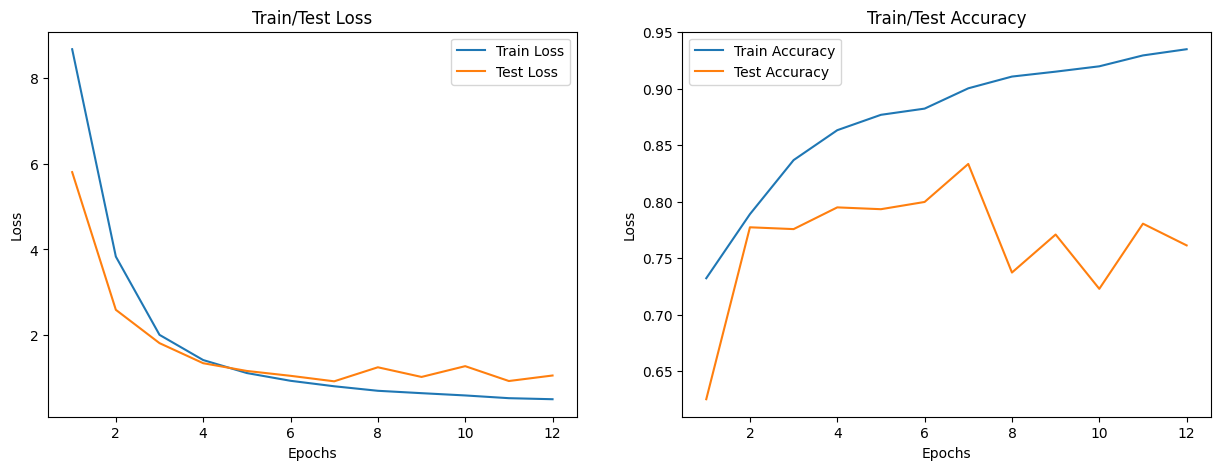

In [7]:
train_loss = normal_history.history['loss']
train_acc = normal_history.history['accuracy']
test_loss = normal_history.history['val_loss']
test_acc = normal_history.history['val_accuracy']
epochs = [i for i in range(1, len(test_acc)+1)]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(epochs, train_loss, label = 'Train Loss')
ax[0].plot(epochs, test_loss, label = 'Test Loss')
ax[0].set_title('Train/Test Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
ax[1].set_title('Train/Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

### AUC and ROC Curves

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


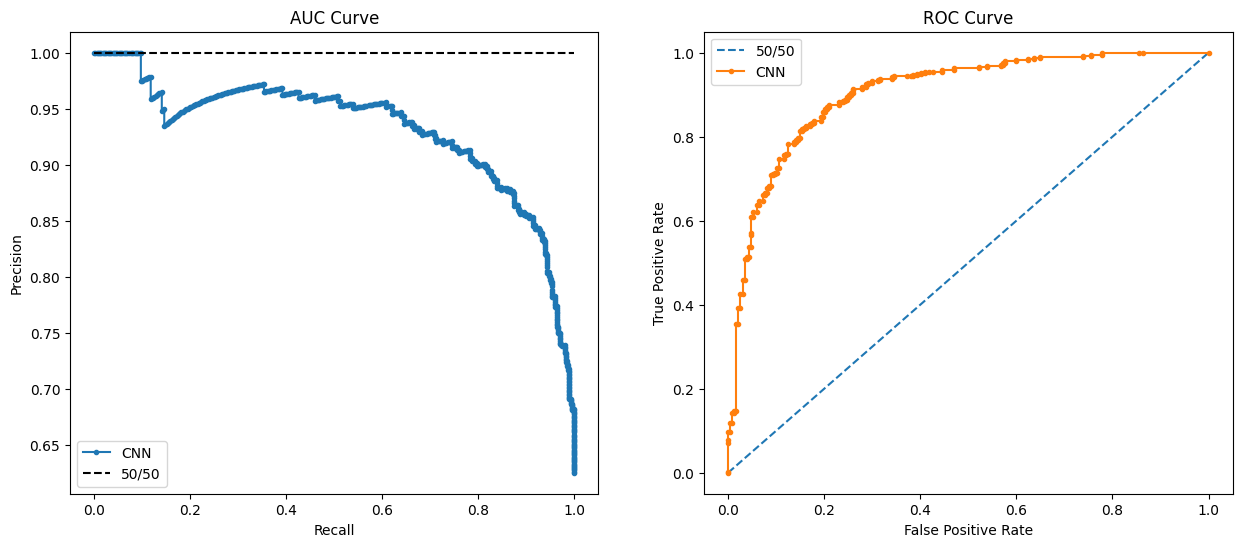

,F1 Score,AUC,ROC
0,0.837,0.932,0.905


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
normal_model = get_conv_model_normal()
normal_model.load_weights('models/CNN-final.h5') #load the best weights before overfitting
 

fig, ax = plt.subplots(1,2, figsize = (15,6))
#AUC CURVE
y_test_prob = normal_model.predict(x_test)

y_test_precision, y_test_recall, spec = precision_recall_curve(y_test, y_test_prob)
y_test_predict = np.where(y_test_prob >= .5, 1, 0).ravel()
y_test_f1= f1_score(y_test, y_test_predict)
y_test_auc = auc(y_test_recall, y_test_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax[0].plot(y_test_recall, y_test_precision, marker='.', label='CNN')
ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='50/50', color = 'Black')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title(f'AUC Curve')
ax[0].legend()

#ROC CURVE
ns_probs = [0 for i in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
y_test_roc = roc_auc_score(y_test, y_test_prob)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
y_test_fpr, y_test_tpr, threshold = roc_curve(y_test, y_test_prob)
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='50/50')
ax[1].plot(y_test_fpr, y_test_tpr, marker='.', label='CNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title(f'ROC Curve')
ax[1].legend()
plt.show()

pd.DataFrame({'F1 Score': round(y_test_f1, 3), 'AUC': round(y_test_auc, 3), 'ROC':round(y_test_roc, 3)}, index = [0])

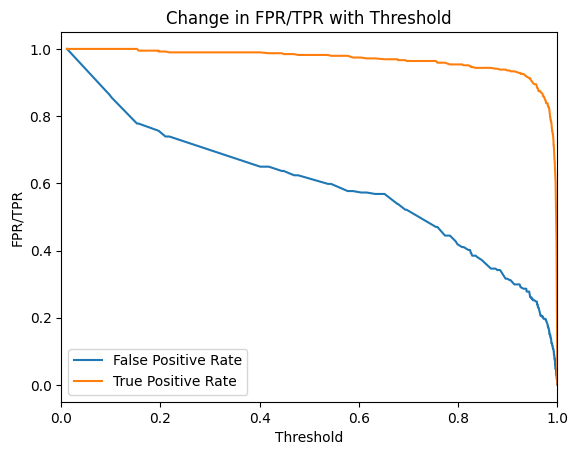

In [9]:
df = pd.DataFrame({'Threshold': threshold, 'FPR': y_test_fpr, 'TPR': y_test_tpr})
plt.plot(df.Threshold, df.FPR, label = 'False Positive Rate')
plt.plot(df.Threshold, df.TPR, label = 'True Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('FPR/TPR')
plt.title('Change in FPR/TPR with Threshold')
plt.xlim(0, 1)
plt.legend()
plt.show()

### Confusion Matrix

C:\Users\haanh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step


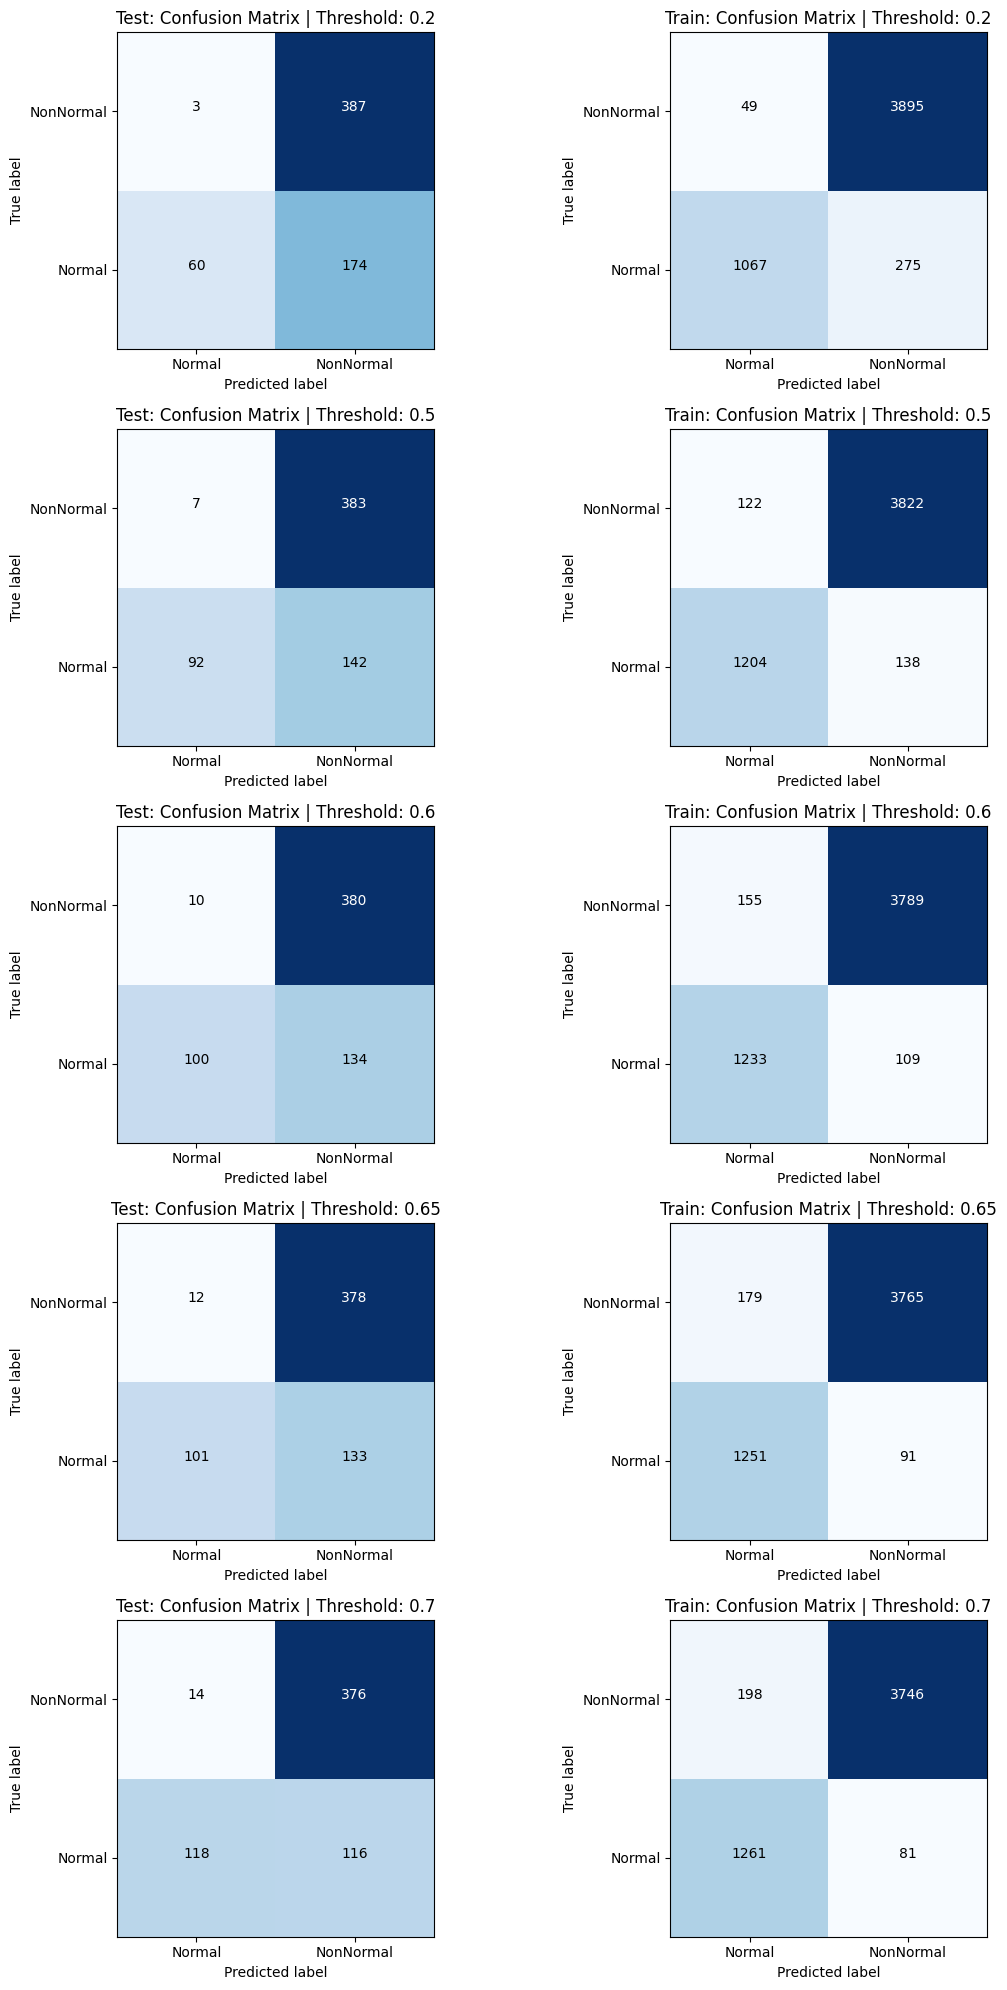

In [10]:
import itertools
import seaborn as sns
def plot_confusion_matrix(y_test,y_train, y_train_prob, y_test_prob,thresholds, classes,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(len(thresholds), 2, figsize=(12, len(thresholds) * 4))

    for idx, thresh in enumerate(thresholds):
        y_test_predict = np.where(y_test_prob >= thresh, 1, 0)
        y_train_predict = np.where(y_train_prob >= thresh, 1, 0)
        train_cm = confusion_matrix(y_train, y_train_predict) 
        test_cm = confusion_matrix(y_test, y_test_predict)
        
        #test confusion
        ax[idx, 0].imshow(test_cm,  cmap=plt.cm.Blues) 

        ax[idx, 0].set_title(f'Test: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 0].set_ylabel('True label')
        ax[idx, 0].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 0].set_xticks(tick_marks)
        ax[idx,0].set_xticklabels(class_names)
        ax[idx, 0].set_yticks(tick_marks)
        ax[idx, 0].set_yticklabels(class_names)

        th = test_cm.max() / 2. 

        for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
                ax[idx, 0].text(j, i, f'{test_cm[i, j]}',# | {int(round(test_cm[i,j]/test_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if test_cm[i, j] > th else 'black')
        ax[idx, 0].set_ylim([-.5,1.5])
        
        #TRAIN CONFUSION
        ax[idx, 1].imshow(train_cm,  cmap=plt.cm.Blues) 

        ax[idx, 1].set_title(f'Train: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 1].set_ylabel('True label')
        ax[idx, 1].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 1].set_xticks(tick_marks)
        ax[idx,1].set_xticklabels(class_names)
        ax[idx, 1].set_yticks(tick_marks)
        ax[idx, 1].set_yticklabels(class_names)


        th = train_cm.max() / 2. 

        for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
                ax[idx, 1].text(j, i, f'{train_cm[i, j]}',# | {int(round(train_cm[i,j]/train_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if train_cm[i, j] > th else 'black')
        ax[idx, 1].set_ylim([-.5,1.5])
    plt.tight_layout()
 
    plt.show()
    
normal_model = get_conv_model_normal()
normal_model.load_weights('models/CNN-final.h5') #load the best weights before overfitting

y_test_prob = normal_model.predict(x_test).ravel()

y_train_prob = normal_model.predict(x_train).ravel()

plot_confusion_matrix(y_train = y_train, y_test = y_test, y_train_prob = y_train_prob,
                      y_test_prob = y_test_prob,classes = ['Normal', 'NonNormal'], thresholds = [.2, .5,.6,.65, .7])

## Test Model
- select any picture from google and put it in the TestImages directory, then replace the path below with that of the new picture. 

In [ ]:
threshold = .75

normal_model = get_conv_model_normal()
normal_model.load_weights('models/CNN-final.h5') # load the best weights

for pic in os.listdir('TestImages'):
    if pic == '.DS_Store' or pic == '.ipynb_checkpoints': 
        continue
    tester_img = get_image_value(f'TestImages/{pic}') 


    tester_img = np.reshape(tester_img, (1,96,96,3))
    normal_predict = normal_model.predict(tester_img).squeeze()
    if normal_predict < threshold: 
        print(f'Actual: {pic}\t\tPrediction: Normal\t\tProbability: {normal_predict}')
    else: 
        print(f'Actual: {pic}\t\tPrediction: Non-Normal\t\tProbability: {normal_predict}')



FileNotFoundError: [Errno 2] No such file or directory: '../TestImages/Bacterial.jpg'